You are evaluating a candidate sentiment model to replace a production baseline. Your goal is to determine whether this model should ship.

“Ship” means: we would choose the candidate model over the baseline for deployment based on the evidence you collect.

### Step 1 - Install the required dependencies, set up W&B and make sure the python version is 3.10 and above

In [62]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import numpy as np
import pandas as pd
import emoji
import wandb

from datasets import load_dataset
from transformers import pipeline

SEED = 42
np.random.seed(SEED)

In [63]:
import os, wandb
wandb.login()

True

In [64]:
!python --version

Python 3.14.0


In [65]:
#imports and config:
import re, regex, emoji
import pandas as pd
import numpy as np
import tqdm

import wandb
from datasets import load_dataset
from transformers import pipeline
import evaluate


# WANDB CONFIG
PROJECT = "mlip-lab4-slices-2026"
ENTITY = None
RUN_NAME = "baseline_vs_candidate"


In [66]:
# Models to compare
MODELS = {
    "baseline_model": "cardiffnlp/twitter-roberta-base-sentiment-latest",
    "candidate_model":    "LYTinn/finetuning-sentiment-model-tweet-gpt2",
}

In [67]:
# Label normalization for tweet_eval (0/1/2 -> string labels)
ID2LABEL = {0: "negative", 1: "neutral", 2: "positive"}

# Many HF sentiment models output labels like LABEL_0 / LABEL_1 / LABEL_2
HF_LABEL_MAP = {"LABEL_0": "negative", "LABEL_1": "neutral", "LABEL_2": "positive"}

USE_HF_DATASET = True  # set False to use tweets.csv fallback

### Step 2 - Load a dataset from Hugging Face

In [68]:
if USE_HF_DATASET:
    ds = load_dataset("cardiffnlp/tweet_eval", "sentiment")
    df = pd.DataFrame(ds["test"]).head(500).copy()
    df["label"] = df["label"].map(ID2LABEL)
else:
    df = pd.read_csv("tweets.csv")
    # Ensure it has 'text' and 'label' columns
    df = df.rename(columns={c: c.strip() for c in df.columns})
    assert {"text","label"}.issubset(df.columns), "tweets.csv must include text,label"
    df["label"] = df["label"].astype(str).str.lower()

df = df[["text","label"]].dropna().reset_index(drop=True)
df.head(3)


,text,label
0,@user @user what do these '1/2 naked pics' hav...,neutral
1,OH: “I had a blue penis while I was this” [pla...,neutral
2,"@user @user That's coming, but I think the vic...",neutral


### Step 3 - Define Failure-Relevant Metadata

In this step, you will create **at least 5** metadata columns that help you slice and analyze model behavior in Weights & Biases (W&B).
These metadata columns should **capture meaningful properties of the data or model behavior that may influence performance**.

Hypothesis-driven slices used below:
1. **Hashtags** (`has_hashtag`): topic or meme tags can shift sentiment and context.
2. **Mentions** (`has_mention`): conversational tweets may be short/ambiguous.
3. **Negation** (`has_negation`): polarity flips can confuse models (e.g., “not good”).
4. **Emoji density** (`emoji_dense`): emojis can signal sentiment not in text.
5. **Unusual length** (`length_bucket`): very short or long tweets may be harder to parse.
6. **URLs** (`has_url`): links reduce sentiment cues and add noise.

Each metadata column corresponds to a hypothesis about when or why a model might succeed or fail.
These columns will be propagated through inference and included in the final predictions_table logged to W&B.

After inference, your W&B table (df_long) will contain:
- The original tweet text
- Ground-truth sentiment labels
- Model predictions and confidence scores
- All metadata columns you defined for slicing

You will use these metadata fields in the W&B UI (via the ➕ Filter option) to:
- Create slices of the data
- Compare model behavior across slices
- Identify patterns, weaknesses, or regressions that are not visible in overall accuracy

In [69]:
# Step 3 – Add slicing metadata (text-only)

# Hypothesis-driven metadata columns
import regex as re2

def count_emojis(text: str) -> int:
    return sum(ch in emoji.EMOJI_DATA for ch in str(text))

# Base metadata
text_len = df["text"].str.len()

df["emoji_count"] = df["text"].apply(count_emojis).astype(int)
df["has_hashtag"] = df["text"].str.contains(r"#\w+", regex=True)
df["has_mention"] = df["text"].str.contains(r"@\w+", regex=True)
df["has_negation"] = df["text"].str.contains(r"\b(not|never|no|can't|won't|isn't|don't|didn't)\b", regex=True)
df["has_url"] = df["text"].str.contains(r"https?://|www\.", regex=True)

# Length buckets (unusual short/long)
df["length_bucket"] = pd.cut(
    text_len,
    bins=[0, 30, 80, 140, 1000, 10_000],
    labels=["0-30", "31-80", "81-140", "141-1000", "1001+"],
    include_lowest=True
).astype(str)

# Emoji density slice (emojis per 100 chars)
df["emoji_density"] = (df["emoji_count"] / text_len.replace(0, 1)) * 100

df["emoji_dense"] = df["emoji_density"] >= 4

# Slice definitions for analysis
# (At least five hypothesis-driven slices)
def get_slices(df_any: pd.DataFrame):
    return {
        "has_hashtag": df_any["has_hashtag"] == True,
        "has_mention": df_any["has_mention"] == True,
        "has_negation": df_any["has_negation"] == True,
        "emoji_dense": df_any["emoji_dense"] == True,
        "short_tweets": df_any["length_bucket"].astype(str).isin(["0-30"]),
        "long_tweets": df_any["length_bucket"].astype(str).isin(["141-1000", "1001+"]),
        "has_url": df_any["has_url"] == True,
    }

C:\Users\jrzem\AppData\Local\Temp\ipykernel_47460\1975077457.py:15: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df["has_negation"] = df["text"].str.contains(r"\b(not|never|no|can't|won't|isn't|don't|didn't)\b", regex=True)


In [70]:
# Transformers requires a backend (PyTorch/TensorFlow/Flax). We'll use PyTorch.
try:
    import torch, transformers, sys
    print("torch:", torch.__version__)
    print("transformers:", transformers.__version__)
    print("CUDA available:", torch.cuda.is_available())
    print("Python:", sys.executable)
except Exception as e:
    raise RuntimeError("Install PyTorch before proceeding: pip install torch torchvision torchaudio") from e

torch: 2.10.0+cpu
transformers: 5.1.0
CUDA available: False
Python: c:\Users\jrzem\OneDrive\Semester Classwork\Graduate\Spring 2026 CMU\Machine Learning in Production AI Engineering\Labs\mlip-model-testing-lab-4\cmu-mlip-model-testing-lab\.venv\Scripts\python.exe


###  Step 4 – Run Inference (Two Models)

In this step, you'll use two HuggingFace sentiment analysis models to run inference on your dataset:

In [71]:
from tqdm.auto import tqdm

def run_pipeline(model_id: str, texts: list[str]):
    clf = pipeline(
        "text-classification",
        model=model_id,
        truncation=True,
        max_length=128,     # avoid truncation warnings
        framework="pt",
        device=-1           # CPU
    )
    # (Optional) sanity check label mapping for this model
    # print(model_id, clf.model.config.id2label)

    preds, confs = [], []
    for t in tqdm(texts, desc=f"Infer: {model_id}"):
        out = clf(t)[0]
        lbl = HF_LABEL_MAP.get(out["label"], out["label"])
        preds.append(lbl)
        confs.append(float(out["score"]))
    return preds, confs

pred_frames = []
texts = df["text"].tolist()

for model_name, model_id in MODELS.items():
    yhat, conf = run_pipeline(model_id, texts)
    tmp = df.copy()
    tmp["model"] = model_name
    tmp["pred"] = yhat
    tmp["conf"] = conf
    pred_frames.append(tmp)

df_long = pd.concat(pred_frames, ignore_index=True)

# Add a stable example id so reshaping won't silently drop duplicates
df_long["ex_id"] = df_long.groupby(["text", "label"]).ngroup()

df_long.head(5)

Loading weights: 100%|██████████| 201/201 [00:00<00:00, 1210.50it/s, Materializing param=roberta.encoder.layer.11.output.dense.weight]              
RobertaForSequenceClassification LOAD REPORT from: cardiffnlp/twitter-roberta-base-sentiment-latest
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.embeddings.position_ids | UNEXPECTED |  | 
roberta.pooler.dense.bias       | UNEXPECTED |  | 
roberta.pooler.dense.weight     | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Infer: cardiffnlp/twitter-roberta-base-sentiment-latest: 100%|██████████| 500/500 [00:15<00:00, 31.95it/s]
Loading weights: 100%|██████████| 149/149 [00:00<00:00, 1094.71it/s, Materializing param=transformer.wte.weight]             
GPT2ForSequenceClassification LOAD REPORT from: LYTinn/finetuning-sentiment-model-tweet-gpt2
Key                                     | Status 

,text,label,emoji_count,has_hashtag,has_mention,has_negation,has_url,length_bucket,emoji_density,emoji_dense,model,pred,conf,ex_id
0,@user @user what do these '1/2 naked pics' hav...,neutral,0,False,True,True,False,81-140,0.0,False,baseline_model,negative,0.804726,113
1,OH: “I had a blue penis while I was this” [pla...,neutral,0,False,False,False,False,31-80,0.0,False,baseline_model,neutral,0.866949,363
2,"@user @user That's coming, but I think the vic...",neutral,0,False,True,False,False,81-140,0.0,False,baseline_model,neutral,0.763724,102
3,I think I may be finally in with the in crowd ...,positive,0,True,True,False,False,81-140,0.0,False,baseline_model,positive,0.774047,305
4,"@user Wow,first Hugo Chavez and now Fidel Cast...",negative,0,False,True,False,False,81-140,0.0,False,baseline_model,neutral,0.416397,160


In [72]:
# Step 4.5 – Wide-format Table for Model Comparison (Optional but recommended)
# One row per tweet, with baseline + candidate predictions in columns
# Updated with custom metadata

df_wide = df_long.pivot_table(
    index=[
        "ex_id", "text", "label",
        "emoji_count", "emoji_density", "emoji_dense",
        "has_hashtag", "has_mention", "has_negation", "has_url",
        "length_bucket"
    ],
    columns="model",
    values=["pred", "conf"],
    aggfunc="first"
).reset_index()

# Flatten column names (e.g., pred_baseline_model, conf_candidate_model)
df_wide.columns = ["_".join([c for c in col if c]).strip("_") for col in df_wide.columns]

df_wide.head(5)

,ex_id,text,label,emoji_count,emoji_density,emoji_dense,has_hashtag,has_mention,has_negation,has_url,length_bucket,conf_baseline_model,conf_candidate_model,pred_baseline_model,pred_candidate_model
0,0,"""Fatty Kim The Third"" 😭😭😭",neutral,3,12.0,True,False,False,False,False,0-30,0.486252,0.978987,neutral,neutral
1,1,"""Focusing on [alt rightists'] respectability.....",neutral,0,0.0,False,False,False,False,False,81-140,0.573571,0.999728,negative,neutral
2,2,"""Kim Fatty the Third""",negative,0,0.0,False,False,False,False,False,0-30,0.849732,0.937709,neutral,neutral
3,3,"""We have lost everything"": Syrians return to r...",neutral,0,0.0,False,True,True,False,False,81-140,0.751955,0.994244,negative,positive
4,4,"""who's the most wiped out white boy? Zac Efron...",neutral,0,0.0,False,False,False,False,False,31-80,0.561232,0.906540,neutral,positive


### Step 5: Compute Metrics (Accuracy + Slice Accuracy + Regression)

In [73]:
# Metrics for overall + slice accuracy

from sklearn.metrics import accuracy_score

def compute_accuracy(y_true, y_pred):
    return accuracy_score(list(y_true), list(y_pred))

# Overall accuracy by model (df_long: one row per (tweet, model))
overall = df_long.groupby("model").apply(
    lambda g: compute_accuracy(g["label"], g["pred"]),
    include_groups=False
)

# Slice accuracy table (uses df_long masks)
slice_table = wandb.Table(columns=["slice", "model", "accuracy"])
slice_metrics = {}

for slice_name, mask in get_slices(df_long).items():
    slice_metrics[slice_name] = {}
    for model_name, g in df_long[mask].groupby("model"):
        acc = float(compute_accuracy(g["label"], g["pred"]))
        slice_table.add_data(slice_name, model_name, acc)
        slice_metrics[slice_name][model_name] = acc

slice_metrics_df = (
    pd.DataFrame(slice_metrics)
    .T
    .reset_index()
    .rename(columns={"index": "slice"})
)

In [74]:
# Regression-aware evaluation (df_eval: one row per tweet, both model outputs) 
# A regression is when the candidate gets something wrong that the baseline got right.
BASELINE = "baseline_model"
CANDIDATE = "candidate_model"

# Ensure ex_id exists (safe even if it already exists)
df_long = df_long.copy()
if "ex_id" not in df_long.columns:
    df_long["ex_id"] = df_long.groupby(["text", "label"]).ngroup()

# Build df_eval with metadata carried through
df_eval = (
    df_long.pivot_table(
        index=[
            "ex_id", "text", "label",
            "emoji_count", "emoji_density", "emoji_dense",
            "has_hashtag", "has_mention", "has_negation", "has_url",
            "length_bucket"
        ],
        columns="model",
        values=["pred", "conf"],
        aggfunc="first"
    )
    .reset_index()
)

# Flatten column names (pred_baseline_model, conf_candidate_model, etc.)
df_eval.columns = ["_".join([c for c in col if c]).strip("_") for col in df_eval.columns]

# Correctness flags
df_eval["baseline_correct"]  = df_eval[f"pred_{BASELINE}"] == df_eval["label"]
df_eval["candidate_correct"] = df_eval[f"pred_{CANDIDATE}"] == df_eval["label"]

# Regression / improvement flags
df_eval["regressed"]   = df_eval["baseline_correct"] & ~df_eval["candidate_correct"]
df_eval["improved"]    = ~df_eval["baseline_correct"] & df_eval["candidate_correct"]
df_eval["both_wrong"]  = ~df_eval["baseline_correct"] & ~df_eval["candidate_correct"]
df_eval["both_correct"]= df_eval["baseline_correct"] & df_eval["candidate_correct"]

# Confidence-conditional regression (candidate is confident AND worse than baseline)
df_eval["confident_regression"] = df_eval["regressed"] & (df_eval[f"conf_{CANDIDATE}"] >= 0.8)

# Global regression metrics
regression_rate = float(df_eval["regressed"].mean())
improvement_rate = float(df_eval["improved"].mean())
conf_reg_rate = float(df_eval["confident_regression"].mean())

print("Regression rate:", regression_rate)
print("Improvement rate:", improvement_rate)
print("Confident regression rate:", conf_reg_rate)

Regression rate: 0.408
Improvement rate: 0.108
Confident regression rate: 0.382


In [75]:
# Slice-level regression metrics

# Define slices on df_eval (must use columns that exist in df_eval)
def get_slices_eval(df_any):
    return {
        "has_hashtag": df_any["has_hashtag"] == True,
        "has_mention": df_any["has_mention"] == True,
        "has_negation": df_any["has_negation"] == True,
        "emoji_dense": df_any["emoji_dense"] == True,
        "short_tweets": df_any["length_bucket"].astype(str).isin(["0-30"]),
        "long_tweets": df_any["length_bucket"].astype(str).isin(["141-1000", "1001+"]),
        "has_url": df_any["has_url"] == True,
    }

# Slice-level regression metrics table
reg_table = wandb.Table(columns=["slice", "metric", "value"])
reg_metrics = {}

for slice_name, mask in get_slices_eval(df_eval).items():
    g = df_eval[mask]
    if len(g) == 0:
        continue

    reg = float(g["regressed"].mean())
    imp = float(g["improved"].mean())
    conf_reg = float(g["confident_regression"].mean())

    reg_table.add_data(slice_name, "regression_rate", reg)
    reg_table.add_data(slice_name, "improvement_rate", imp)
    reg_table.add_data(slice_name, "confident_regression_rate", conf_reg)

    reg_metrics[slice_name] = {
        "regression_rate": reg,
        "improvement_rate": imp,
        "conf_reg_rate": conf_reg
    }

regression_metrics_df = (
    pd.DataFrame(reg_metrics)
    .T
    .reset_index()
    .rename(columns={"index": "slice"})
)


### Showcase Visual Performance from Slices:

C:\Users\jrzem\AppData\Local\Temp\ipykernel_47460\3921555896.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(slice_long["slice"].unique(), rotation=45, ha="right")


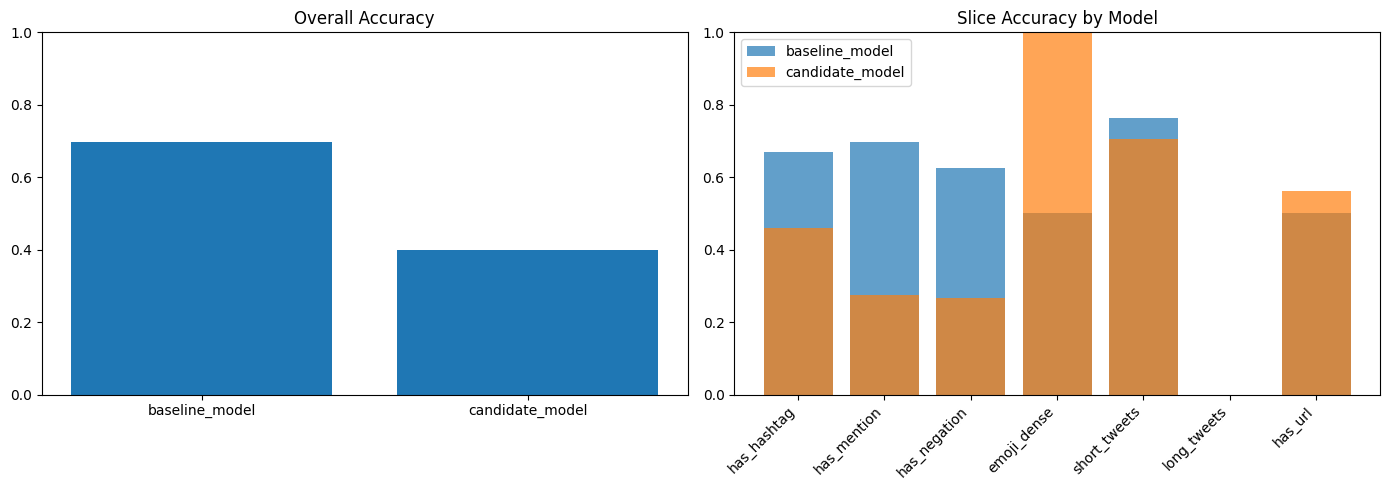

In [76]:
try:
    import matplotlib.pyplot as plt
except ModuleNotFoundError:
    print("matplotlib not installed. Run 'pip install matplotlib' for local plots.")
    plt = None

if plt is not None:
    # Overall accuracy
    overall_df = overall.reset_index()
    overall_df.columns = ["model", "accuracy"]

    # Slice accuracy (from slice_metrics_df created in Step 5)
    slice_long = slice_metrics_df.melt(id_vars=["slice"], var_name="model", value_name="accuracy")

    # Plot overall + slices
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].bar(overall_df["model"], overall_df["accuracy"])
    axes[0].set_title("Overall Accuracy")
    axes[0].set_ylim(0, 1)

    for m in slice_long["model"].unique():
        subset = slice_long[slice_long["model"] == m]
        axes[1].bar(subset["slice"], subset["accuracy"], alpha=0.7, label=m)

    axes[1].set_title("Slice Accuracy by Model")
    axes[1].set_xticklabels(slice_long["slice"].unique(), rotation=45, ha="right")
    axes[1].set_ylim(0, 1)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# Step 6 — #TODO: Log to W&B & Analyse Slices
# (Make sure PROJECT/ENTITY/RUN_NAME exist from Step 1)

In [77]:
# Step 6: Log to W&B

PROJECT = "mlip-lab4-slices-2026"
ENTITY = None
RUN_NAME = "baseline_vs_candidate"
run = wandb.init(project=PROJECT, entity=ENTITY, name=RUN_NAME)

# Required dataframes
wandb.log({"df_long": wandb.Table(dataframe=df_long)})
wandb.log({"slice_metrics": wandb.Table(dataframe=slice_metrics_df)})
wandb.log({"regression_metrics": wandb.Table(dataframe=regression_metrics_df)})
wandb.log({"df_eval": wandb.Table(dataframe=df_eval)})

# Also log the prebuilt tables for easy charting
wandb.log({"predictions_table": wandb.Table(dataframe=df_long)})
wandb.log({"slice_table": slice_table})
wandb.log({"regression_table": reg_table})

# If the UI plot isn't accessible, log a bar chart directly
slice_long = slice_metrics_df.melt(id_vars=["slice"], var_name="model", value_name="accuracy")
wandb.log({
    "slice_accuracy_chart": wandb.plot.bar(
        table=wandb.Table(dataframe=slice_long),
        label="slice",
        value="accuracy",
        title="Slice Accuracy by Model"
    )
})

for model_name, acc in overall.items():
    wandb.summary[f"{model_name}_accuracy"] = float(acc)
wandb.summary["regression_rate"] = regression_rate
wandb.summary["improvement_rate"] = improvement_rate
wandb.summary["confident_regression_rate"] = conf_reg_rate

print("W&B run URL:", run.get_url())
run.finish()

W&B run URL: https://wandb.ai/jzembowe-carnegie-mellon-university/mlip-lab4-slices-2026/runs/h7rysp3n


baseline_model_accuracy,0.698
candidate_model_accuracy,0.398
confident_regression_rate,0.382
improvement_rate,0.108
regression_rate,0.408


### Instructions: Exploring Slice-Based Evaluation in W&B

# Purpose
In this lab, you are evaluating a candidate sentiment model to decide whether it should replace an existing baseline (production) model.
You have already:
  - run both models on the same dataset
  - logged predictions, confidence scores, and metadata to W&B
  - created metadata that allows you to slice the data
The most important goal is to understand when and why models behave differently.
Overall accuracy alone is often misleading.

# What to do in W&B
1. Open your W&B run
  - Click the project link and open the latest run.
2. Explore the predictions table
  - Go to the Tables tab and open predictions_table.
  - Each row is one tweet × one model.
3. Create and analyze slices (most important)
  - Use filters to create meaningful slices 
    (e.g., negation, emojis, hashtags, long tweets).
  - For each slice:
    - Compare baseline vs candidate performance.
    - Compare slice accuracy to overall accuracy.
    - Inspect a few misclassified examples to identify patterns.
4. Visualize slice performance
  - Open slice_metrics.
  - Create bar charts comparing baseline vs candidate accuracy for at least two slices.
5. Discuss your findings with the TA
  - Explain why slicing reveals issues that overall accuracy hides.
  - Say whether the candidate model should be deployed and why.


In [78]:
# Students: replace the placeholders below with 1–2 sentence insights
saved_slice_notes = [
    "Hashtags: topic tags can change context; accuracy may drift on meme or event tags.",
    "Mentions: conversational tweets are often short and ambiguous, which can reduce sentiment clarity.",
    "Negation: polarity flips (e.g., ‘not good’) are common failure modes for sentiment models.",
    "Emoji-dense: emojis often carry sentiment not stated in text, so misreads can spike.",
    "Short tweets: very short text can be too sparse for reliable sentiment.",
    "Long tweets: longer tweets may contain mixed sentiment and confuse single-label models.",
    "URLs: link-heavy tweets reduce explicit sentiment cues and add noise.",
]

pd.DataFrame(saved_slice_notes)

,0
0,Hashtags: topic tags can change context; accur...
1,Mentions: conversational tweets are often shor...
2,"Negation: polarity flips (e.g., ‘not good’) ar..."
3,Emoji-dense: emojis often carry sentiment not ...
4,Short tweets: very short text can be too spars...
5,Long tweets: longer tweets may contain mixed s...
6,URLs: link-heavy tweets reduce explicit sentim...


### Step 7 - Targeted stress testing with LLMs

TODO: 
In this step, you will use a Large Language Model (LLM) to generate test cases that specifically target a weakness you observed during slicing.

What to do:
1. Choose one slice where you noticed poor performance, regressions, or surprising behavior.
2. Write a short hypothesis (1–2 sentences) explaining why the model might struggle on this slice. Example:
“The model struggles with tweets that use slang and sarcasm.”
3. Use an LLM to generate 10 test cases designed to test this hypothesis.
These can include:
    - subtle or ambiguous cases
    - difficult or adversarial cases
    - small wording changes that affect sentiment
4. Re-run both models on the generated test cases (helper script given below.)
5. Briefly describe what you observed to the TA:
    - Did the same failures appear again?
    - notice any new failure patterns?
    - would this affect your confidence in deploying the model?

Your input can be in the following format:

> Examples:
> - @user @user That’s coming, but I think the victims are going to be Medicaid recipients.
> - I think I may be finally in with the in crowd #mannequinchallenge  #grads2014 @user
> 
> Generate more tweets using slangs.

Use our provided GPTs to start the task: [llm-based-test-case-generator](https://chatgpt.com/g/g-982cylVn2-llm-based-test-case-generator). If you do not have access to GPTs, use the plain ChatGPT or other LLM providers you have access to instead.

In [79]:
# TODO: Paste your 10 generated tweets here:
generated_slice_description = (
    "Weak slice selected: negation. Hypothesis: models struggle to flip polarity when negation "
    "(not/never/don’t/ can’t) appears near sentiment words."
)

generated_cases = [
    "This is not good at all.",
    "I don't love this update, honestly.",
    "Not bad, but not great either.",
    "I can't say I'm happy with this service.",
    "Never thought I'd dislike this feature so much.",
    "I don't hate it, but I don't like it either.",
    "This is not the worst, but it's not fine.",
    "I didn't enjoy that experience.",
    "I'm not excited about the changes.",
    "Not impressed by the new design.",
]

In [80]:
#Helper code to run models on synthetic test cases:

def run_on_generated_tests(texts, models=MODELS):
    rows = []
    for model_name, model_id in models.items():
        clf = pipeline(
            "text-classification",
            model=model_id,
            truncation=True,
            framework="pt",
            device=-1
        )
        for t in texts:
            out = clf(t)[0]
            rows.append({
                "text": t,
                "model": model_name,
                "pred": HF_LABEL_MAP.get(out["label"], out["label"]),
                "conf": float(out["score"])
            })
    return pd.DataFrame(rows)


In [81]:
generated_df = run_on_generated_tests(generated_cases)
generated_df

Loading weights: 100%|██████████| 201/201 [00:00<00:00, 1290.40it/s, Materializing param=roberta.encoder.layer.11.output.dense.weight]              
RobertaForSequenceClassification LOAD REPORT from: cardiffnlp/twitter-roberta-base-sentiment-latest
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.embeddings.position_ids | UNEXPECTED |  | 
roberta.pooler.dense.bias       | UNEXPECTED |  | 
roberta.pooler.dense.weight     | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Loading weights: 100%|██████████| 149/149 [00:00<00:00, 1302.13it/s, Materializing param=transformer.wte.weight]             
GPT2ForSequenceClassification LOAD REPORT from: LYTinn/finetuning-sentiment-model-tweet-gpt2
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
transformer.h.{0...11}.attn.bias      

,text,model,pred,conf
0,This is not good at all.,baseline_model,negative,0.924885
1,"I don't love this update, honestly.",baseline_model,negative,0.940950
2,"Not bad, but not great either.",baseline_model,negative,0.767315
3,I can't say I'm happy with this service.,baseline_model,negative,0.733696
4,Never thought I'd dislike this feature so much.,baseline_model,negative,0.907429
5,"I don't hate it, but I don't like it either.",baseline_model,negative,0.793088
6,"This is not the worst, but it's not fine.",baseline_model,negative,0.877530
7,I didn't enjoy that experience.,baseline_model,negative,0.900324
8,I'm not excited about the changes.,baseline_model,negative,0.836788
9,Not impressed by the new design.,baseline_model,negative,0.869310


In [82]:
# OPTIONAL: Log synthetic test cases to W&B
run = wandb.init(project=PROJECT, entity=ENTITY, name=RUN_NAME + "_synthetic")
wandb.log({"synthetic_tests": wandb.Table(dataframe=generated_df)})
run.finish()